# 2.1 Obtaining road data in San Francisco (OSMNX data set)
First, we use the OSMNX API and the graph_from_place () method. As a parameter we give network_type = "drive_service", because the roads in San Francisco are the most important for us.

C:\Users\Daniel\.conda\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


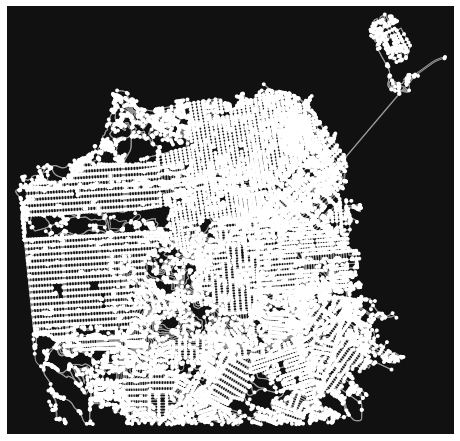

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
import osmnx as ox
G = ox.graph_from_place('San Francisco, California', network_type='drive_service')
ox.plot_graph(G)

### Above we can see a beautiful graph with roads


### Then we convert the graph to Geo Data Frame

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle as pkl

### The special graph_to_gdfs method returns a tuple with nodes and edges

In [3]:
nodes, edges = ox.graph_to_gdfs(G)
edges

osmid  \
u          v          key                                                      
32927563   645559609  0                     [50690291, 179235221, 661905446]   
32927591   315706881  0                                             28715659   
           6469349533 0                                            689603997   
32927645   65331336   0                        [28846637, 8918870, 61424023]   
           766946830  0    [8915137, 33645923, 33645968, 28656664, 61424026]   
...                                                                      ...   
9728390500 9728390499 0                                           1058733099   
9765282208 259141386  0                                             23908176   
           65323085   0                                             32928788   
           65296736   0                                             32928788   
9781183485 3458064558 0                  [1065081988, 1065081989, 104110094]   

                           oneway lanes    ref  \
u          v          key                        
32927563   645559609  0      True     5   I 80   
32927591   315706881  0      True     1    NaN   
           6469349533 0      True     4  I 280   
32927645   65331336   0      True     2  I 280   
           766946830  0      True     2    NaN   
...                           ...   ...    ...   
9728390500 9728390499 0     False   NaN    NaN   
9765282208 259141386  0     False   NaN    NaN   
           65323085   0     False     2    NaN   
           65296736   0     False     2    NaN   
9781183485 3458064558 0     False   NaN    NaN   

                                                         name        highway  \
u          v          key                                                      
32927563   645559609  0    San Francisco – Oakland Bay Bridge       motorway   
32927591   315706881  0                                   NaN  motorway_link   
           6469349533 0                  John F Foran Freeway       motorway   
32927645   65331336   0          Southern Embarcadero Freeway       motorway   
           766946830  0                                   NaN  motorway_link   
...                                                       ...            ...   
9728390500 9728390499 0                                   NaN        service   
9765282208 259141386  0                                   NaN        service   
           65323085   0       Martin Luther King Junior Drive       tertiary   
           65296736   0       Martin Luther King Junior Drive       tertiary   
9781183485 3458064558 0                       Arellano Avenue        service   

                          maxspeed    length bridge  \
u          v          key                             
32927563   645559609  0     50 mph  3232.712    yes   
32927591   315706881  0        NaN   333.165    NaN   
           6469349533 0     65 mph   794.493    NaN   
32927645   65331336   0     65 mph  1196.665    yes   
           766946830  0     50 mph  1174.585    yes   
...                            ...       ...    ...   
9728390500 9728390499 0        NaN    14.643    NaN   
9765282208 259141386  0        NaN    33.416    NaN   
           65323085   0        NaN    41.427    NaN   
           65296736   0        NaN    38.591    NaN   
9781183485 3458064558 0        NaN    97.966    NaN   

                                                                    geometry  \
u          v          key                                                      
32927563   645559609  0    LINESTRING (-122.39094 37.78592, -122.39068 37...   
32927591   315706881  0    LINESTRING (-122.42412 37.73135, -122.42362 37...   
           6469349533 0    LINESTRING (-122.42412 37.73135, -122.42396 37...   
32927645   65331336   0    LINESTRING (-122.41326 37.73271, -122.41224 37...   
           766946830  0    LINESTRING (-122.41326 37.73271, -122.41217 37...   
...                                                           

# 2.2 Data cleaning and preparing for ML model (OSMNX data set)

In [4]:
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 40567 entries, (32927563, 645559609, 0) to (9781183485, 3458064558, 0)
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     40567 non-null  object  
 1   oneway    40567 non-null  bool    
 2   lanes     11540 non-null  object  
 3   ref       528 non-null    object  
 4   name      32918 non-null  object  
 5   highway   40567 non-null  object  
 6   maxspeed  7308 non-null   object  
 7   length    40567 non-null  float64 
 8   bridge    262 non-null    object  
 9   geometry  40567 non-null  geometry
 10  access    962 non-null    object  
 11  service   1800 non-null   object  
 12  junction  167 non-null    object  
 13  tunnel    72 non-null     object  
 14  width     85 non-null     object  
dtypes: bool(1), float64(1), geometry(1), object(12)
memory usage: 5.8+ MB


### Our data collection has many disadvantages: 
- Senseless indexes "u", "v", "key"
- The "osmid" column is not needed at all for machine learning.
- Columns like "access", "junction", "service", "width", "tunnel" contain many NaNs.
- "maxspeed" should be float

### 2.2.1 Dropping unnecessary columns

In [5]:
edges = edges.reset_index()
edges.drop(columns=['u','v','osmid','key'], inplace = True)

### 2.2.2 "maxspeed" column
First we are checking if all values have miles per hour unit

In [6]:
edges['maxspeed'].value_counts()

25 mph              4203
30 mph              1079
35 mph              1030
20 mph               397
15 mph               147
40 mph               118
50 mph               102
45 mph                88
10 mph                38
65 mph                35
55 mph                26
5 mph                 12
[25 mph, 20 mph]       5
[25 mph, 35 mph]       4
[40 mph, 35 mph]       4
[55 mph, 50 mph]       4
[35 mph, 45 mph]       3
[30 mph, 20 mph]       2
[40 mph, 45 mph]       2
[30 mph, 35 mph]       2
[30 mph, 40 mph]       2
[65 mph, 45 mph]       1
[25 mph, 45 mph]       1
[40 mph, 50 mph]       1
[45 mph, 35 mph]       1
[45 mph, 50 mph]       1
Name: maxspeed, dtype: int64

In [7]:
edges['maxspeed'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 40567 entries, 0 to 40566
Series name: maxspeed
Non-Null Count  Dtype 
--------------  ----- 
7308 non-null   object
dtypes: object(1)
memory usage: 317.1+ KB


As we see all values have the same unit, but some records have list instead of scalar value.
We have also many NaNs.

### 2.2.2a one hot encoding for maxspeed column

In [8]:
dummies =  pd.get_dummies(edges['maxspeed'].apply(pd.Series).stack(),prefix="maxspeed").sum(level=0)
edges.drop(columns=['maxspeed'], inplace = True)
edges = edges.join(dummies)
edges

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\102301690.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies =  pd.get_dummies(edges['maxspeed'].apply(pd.Series).stack(),prefix="maxspeed").sum(level=0)


,oneway,lanes,ref,name,highway,length,bridge,geometry,access,service,...,maxspeed_20 mph,maxspeed_25 mph,maxspeed_30 mph,maxspeed_35 mph,maxspeed_40 mph,maxspeed_45 mph,maxspeed_5 mph,maxspeed_50 mph,maxspeed_55 mph,maxspeed_65 mph
0,True,5,I 80,San Francisco – Oakland Bay Bridge,motorway,3232.712,yes,"LINESTRING (-122.39094 37.78592, -122.39068 37...",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,True,1,NaN,NaN,motorway_link,333.165,NaN,"LINESTRING (-122.42412 37.73135, -122.42362 37...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,4,I 280,John F Foran Freeway,motorway,794.493,NaN,"LINESTRING (-122.42412 37.73135, -122.42396 37...",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,True,2,I 280,Southern Embarcadero Freeway,motorway,1196.665,yes,"LINESTRING (-122.41326 37.73271, -122.41224 37...",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,True,2,NaN,NaN,motorway_link,1174.585,yes,"LINESTRING (-122.41326 37.73271, -122.41217 37...",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40562,False,NaN,NaN,NaN,service,14.643,NaN,"LINESTRING (-122.42627 37.78316, -122.42628 37...",NaN,driveway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40563,False,NaN,NaN,NaN,service,33.416,NaN,"LINESTRING (-122.47293 37.76724, -122.47286 37...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40564,False,2,NaN,Martin Luther King Junior Drive,tertiary,41.427,NaN,"LINESTRING (-122.47293 37.76724, -122.47295 37...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40565,False,2,NaN,Martin Luther King Junior Drive,tertiary,38.591,NaN,"LINESTRING (-122.47293 37.76724, -122.47289 37...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2.2b Fill NaN with 0 value

In [9]:
import re
r = re.compile("maxspeed.*")
maxspeed_cols = list(filter(r.match, list(edges.columns)))
edges[maxspeed_cols] = edges[maxspeed_cols].fillna(value=0)

In [10]:
edges[maxspeed_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   maxspeed_10 mph  40567 non-null  float64
 1   maxspeed_15 mph  40567 non-null  float64
 2   maxspeed_20 mph  40567 non-null  float64
 3   maxspeed_25 mph  40567 non-null  float64
 4   maxspeed_30 mph  40567 non-null  float64
 5   maxspeed_35 mph  40567 non-null  float64
 6   maxspeed_40 mph  40567 non-null  float64
 7   maxspeed_45 mph  40567 non-null  float64
 8   maxspeed_5 mph   40567 non-null  float64
 9   maxspeed_50 mph  40567 non-null  float64
 10  maxspeed_55 mph  40567 non-null  float64
 11  maxspeed_65 mph  40567 non-null  float64
dtypes: float64(12)
memory usage: 3.7 MB


### 2.2.3 "oneway" column

In [11]:
edges['oneway'].value_counts()

False    33502
True      7065
Name: oneway, dtype: int64

### 2.2.3a One hot encoding for oneway column

In [12]:
dummies = pd.get_dummies(edges['oneway'],prefix="oneway")
edges.drop(columns=['oneway'], inplace = True)
edges = edges.join(dummies)

### 2.2.3b Fill NaN with 0 value

In [13]:
r = re.compile("oneway.*")
oneway_cols = list(filter(r.match, list(edges.columns)))
edges[oneway_cols] = edges[oneway_cols].fillna(value=0)

In [14]:
edges[oneway_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   oneway_False  40567 non-null  uint8
 1   oneway_True   40567 non-null  uint8
dtypes: uint8(2)
memory usage: 79.4 KB


In [15]:
edges[oneway_cols].head(10)

,oneway_False,oneway_True
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,1,0
7,0,1
8,1,0
9,1,0


### 2.2.4 "lanes" column

In [16]:
edges['lanes'].value_counts()

2               6339
3               1834
4               1547
1                674
[2, 3]           436
5                222
[4, 3]           165
[5, 4]            91
[1, 2]            86
6                 37
[4, 2]            36
[5, 3]            21
[4, 2, 3]         21
[1, 2, 3]          8
[5, 6]             7
8                  3
[4, 6]             2
[7, 6]             2
[1, 3]             2
[5, 4, 3]          2
[5, 2]             2
[4, 1, 2]          1
[8, 1]             1
[5, 4, 2, 3]       1
Name: lanes, dtype: int64

### 2.2.4a One hot encoding for lanes column

In [17]:
dummies =  pd.get_dummies(edges['lanes'].apply(pd.Series).stack(),prefix="lanes").sum(level=0)
edges.drop(columns=['lanes'], inplace = True)
edges = edges.join(dummies)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\2973013978.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies =  pd.get_dummies(edges['lanes'].apply(pd.Series).stack(),prefix="lanes").sum(level=0)


### 2.2.4b Fill NaN with 0 value

In [18]:
r = re.compile("lanes.*")
lanes_cols = list(filter(r.match, list(edges.columns)))
edges[lanes_cols] = edges[lanes_cols].fillna(value=0)

In [19]:
edges[lanes_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lanes_1  40567 non-null  float64
 1   lanes_2  40567 non-null  float64
 2   lanes_3  40567 non-null  float64
 3   lanes_4  40567 non-null  float64
 4   lanes_5  40567 non-null  float64
 5   lanes_6  40567 non-null  float64
 6   lanes_7  40567 non-null  float64
 7   lanes_8  40567 non-null  float64
dtypes: float64(8)
memory usage: 2.5 MB


In [20]:
edges[lanes_cols].head(10)

,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,lanes_8
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2.5 "highway" column

In [21]:
edges['highway'].value_counts()

residential                    20611
service                         8192
tertiary                        4709
secondary                       3532
primary                         1665
unclassified                     767
trunk                            310
motorway_link                    146
motorway                         124
primary_link                     112
busway                            96
secondary_link                    87
[residential, service]            78
trunk_link                        31
tertiary_link                     31
living_street                     25
[residential, unclassified]       19
[unclassified, service]           12
[tertiary, unclassified]           5
[tertiary, secondary]              4
[tertiary, service]                4
[residential, tertiary]            3
[tertiary, residential]            2
[tertiary, motorway_link]          1
[primary_link, secondary]          1
Name: highway, dtype: int64

### 2.2.5a One hot encoding for highway column

In [22]:
dummies =  pd.get_dummies(edges['highway'].apply(pd.Series).stack(),prefix="highway").sum(level=0)
edges.drop(columns=['highway'], inplace = True)
edges = edges.join(dummies)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\364594632.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies =  pd.get_dummies(edges['highway'].apply(pd.Series).stack(),prefix="highway").sum(level=0)


### 2.2.5b Fill NaN with 0 value

In [23]:
r = re.compile("highway.*")
highway_cols = list(filter(r.match, list(edges.columns)))
edges[highway_cols] = edges[highway_cols].fillna(value=0)

In [24]:
edges[highway_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   highway_busway          40567 non-null  uint8
 1   highway_living_street   40567 non-null  uint8
 2   highway_motorway        40567 non-null  uint8
 3   highway_motorway_link   40567 non-null  uint8
 4   highway_primary         40567 non-null  uint8
 5   highway_primary_link    40567 non-null  uint8
 6   highway_residential     40567 non-null  uint8
 7   highway_secondary       40567 non-null  uint8
 8   highway_secondary_link  40567 non-null  uint8
 9   highway_service         40567 non-null  uint8
 10  highway_tertiary        40567 non-null  uint8
 11  highway_tertiary_link   40567 non-null  uint8
 12  highway_trunk           40567 non-null  uint8
 13  highway_trunk_link      40567 non-null  uint8
 14  highway_unclassified    40567 non-null  uint8
dtypes: uint8(15)
memory

In [25]:
edges[highway_cols].head(10)

,highway_busway,highway_living_street,highway_motorway,highway_motorway_link,highway_primary,highway_primary_link,highway_residential,highway_secondary,highway_secondary_link,highway_service,highway_tertiary,highway_tertiary_link,highway_trunk,highway_trunk_link,highway_unclassified
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [26]:
osmnx_data = edges
osmnx_data.head(10)

,ref,name,length,bridge,geometry,access,service,junction,tunnel,width,...,highway_primary_link,highway_residential,highway_secondary,highway_secondary_link,highway_service,highway_tertiary,highway_tertiary_link,highway_trunk,highway_trunk_link,highway_unclassified
0,I 80,San Francisco – Oakland Bay Bridge,3232.712,yes,"LINESTRING (-122.39094 37.78592, -122.39068 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,333.165,NaN,"LINESTRING (-122.42412 37.73135, -122.42362 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,I 280,John F Foran Freeway,794.493,NaN,"LINESTRING (-122.42412 37.73135, -122.42396 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,I 280,Southern Embarcadero Freeway,1196.665,yes,"LINESTRING (-122.41326 37.73271, -122.41224 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,1174.585,yes,"LINESTRING (-122.41326 37.73271, -122.41217 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,NaN,Chestnut Street,20.325,NaN,"LINESTRING (-122.40345 37.80504, -122.40355 37...",NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
6,NaN,NaN,12.520,NaN,"LINESTRING (-122.40345 37.80504, -122.40337 37...",NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
7,NaN,The Embarcadero,30.791,NaN,"LINESTRING (-122.40345 37.80504, -122.40333 37...",NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,NaN,Macondray Lane,75.108,NaN,"LINESTRING (-122.41648 37.79905, -122.41733 37...",NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
9,NaN,4th Street,101.120,NaN,"LINESTRING (-122.39119 37.77058, -122.39119 37...",NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0


# 2.3 Obtaining speed limit data in San Francisco (SanFranciscoSpeedLimitCompliance data set) 

In [27]:
df = pd.read_csv('./data/SanFranciscoSpeedLimitCompliance.csv')
from shapely import wkt
df['the_geom'] = df['the_geom'].apply(wkt.loads)
gdfSpeed = gpd.GeoDataFrame(df, crs='epsg:4326')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\2503447945.py:4: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdfSpeed = gpd.GeoDataFrame(df, crs='epsg:4326')


In [28]:
gdfSpeed

,CNN,the_geom,SpeedLimit,STREETNAME,Over_pct,O5mph_pct,Speed_avg,SpeedO_avg,Spd5O_avg
0,6709000,LINESTRING (-122.39031948388298 37.78813450234...,30,HARRISON ST,39.77,11.11,28.40,33.76,38.32
1,6710000,LINESTRING (-122.39117965804613 37.78745518697...,30,HARRISON ST,39.77,11.11,28.40,33.76,38.32
2,6719000,LINESTRING (-122.39961623244395 37.78079148306...,30,HARRISON ST,48.00,15.00,29.55,33.88,38.00
3,194101,LINESTRING (-122.38775628064698 37.75283561191...,30,3RD ST,58.50,25.50,31.26,34.89,38.63
4,194201,LINESTRING (-122.38775628064698 37.75283561191...,30,3RD ST,58.50,25.50,31.26,34.89,38.63
...,...,...,...,...,...,...,...,...,...
608,409000,LINESTRING (-122.41160611273487 37.77622135626...,30,8TH ST,16.00,1.00,26.20,32.31,37.00
609,410000,LINESTRING (-122.41106944267237 37.77579380416...,30,8TH ST,16.00,1.00,26.20,32.31,37.00
610,411000,LINESTRING (-122.41061072931767 37.77542835163...,30,8TH ST,16.00,1.00,26.20,32.31,37.00
611,415000,LINESTRING (-122.40851633075071 37.77375969975...,30,8TH ST,18.00,0.00,25.10,32.00,0.00


In [29]:
gdfSpeed.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CNN         613 non-null    int64  
 1   the_geom    613 non-null    object 
 2   SpeedLimit  613 non-null    int64  
 3   STREETNAME  613 non-null    object 
 4   Over_pct    613 non-null    float64
 5   O5mph_pct   613 non-null    float64
 6   Speed_avg   613 non-null    float64
 7   SpeedO_avg  613 non-null    float64
 8   Spd5O_avg   613 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 43.2+ KB


# 2.4 Data cleaning and preparing for ML model (SanFranciscoSpeedLimitCompliance data set) 

### 2.4.1 Dropping unnecessary column

In [30]:
gdfSpeed.drop(columns=['CNN'], inplace = True)

### 2.4.2 "SpeedLimit" column

In [31]:
gdfSpeed['SpeedLimit'].value_counts()

0     186
25    171
35    146
30    110
Name: SpeedLimit, dtype: int64

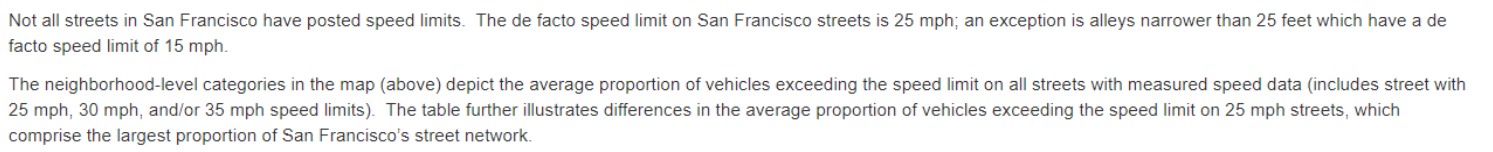

In [32]:
gdfSpeed['SpeedLimit'].replace({0:25}, inplace=True)

In [33]:
### 2.4.3 "the_geom" column

In [34]:
gdfSpeed = gdfSpeed.rename(columns ={'the_geom':'geometry'})

In [35]:
gdfSpeed["geometry"] = gdfSpeed.buffer(0.0001)

In [36]:
gdfSpeed.head()

,geometry,SpeedLimit,STREETNAME,Over_pct,O5mph_pct,Speed_avg,SpeedO_avg,Spd5O_avg
0,"POLYGON ((-122.39112 37.78738, -122.39113 37.7...",30,HARRISON ST,39.77,11.11,28.40,33.76,38.32
1,"POLYGON ((-122.39199 37.78669, -122.39200 37.7...",30,HARRISON ST,39.77,11.11,28.40,33.76,38.32
2,"POLYGON ((-122.40178 37.77895, -122.40179 37.7...",30,HARRISON ST,48.00,15.00,29.55,33.88,38.00
3,"POLYGON ((-122.38761 37.75282, -122.38760 37.7...",30,3RD ST,58.50,25.50,31.26,34.89,38.63
4,"POLYGON ((-122.38771 37.75272, -122.38761 37.7...",30,3RD ST,58.50,25.50,31.26,34.89,38.63


In [37]:
speed_limit_data = gdfSpeed

# 2.5 Merging datasets

In [38]:
merged = gpd.sjoin(speed_limit_data.set_geometry("geometry"), osmnx_data[osmnx_data.columns], how='inner', predicate='contains')

In [39]:
merged.head(2)

,geometry,SpeedLimit,STREETNAME,Over_pct,O5mph_pct,Speed_avg,SpeedO_avg,Spd5O_avg,index_right,ref,...,highway_primary_link,highway_residential,highway_secondary,highway_secondary_link,highway_service,highway_tertiary,highway_tertiary_link,highway_trunk,highway_trunk_link,highway_unclassified
2,"POLYGON ((-122.40178 37.77895, -122.40179 37.7...",30,HARRISON ST,48.0,15.0,29.55,33.88,38.0,34497,NaN,...,0,0,1,0,0,0,0,0,0,0
2,"POLYGON ((-122.40178 37.77895, -122.40179 37.7...",30,HARRISON ST,48.0,15.0,29.55,33.88,38.0,34495,NaN,...,0,0,1,0,0,0,0,0,0,0


In [40]:
merged.reset_index(inplace = True)
merged.drop_duplicates(subset=["geometry"], inplace=True)
merged.reset_index(inplace=True)
merged.drop(columns=["level_0", "index", "STREETNAME", "index_right"], inplace=True)
merged

,geometry,SpeedLimit,Over_pct,O5mph_pct,Speed_avg,SpeedO_avg,Spd5O_avg,ref,name,length,...,highway_primary_link,highway_residential,highway_secondary,highway_secondary_link,highway_service,highway_tertiary,highway_tertiary_link,highway_trunk,highway_trunk_link,highway_unclassified
0,"POLYGON ((-122.40178 37.77895, -122.40179 37.7...",30,48.00,15.0,29.55,33.88,38.00,NaN,Harrison Street,23.372,...,0,0,1,0,0,0,0,0,0,0
1,"POLYGON ((-122.38761 37.75282, -122.38760 37.7...",30,58.50,25.5,31.26,34.89,38.63,NaN,26th Street,13.634,...,0,0,0,0,0,0,0,0,0,1
2,"POLYGON ((-122.38771 37.75272, -122.38761 37.7...",30,58.50,25.5,31.26,34.89,38.63,NaN,26th Street,13.634,...,0,0,0,0,0,0,0,0,0,1
3,"POLYGON ((-122.38748 37.75153, -122.38748 37.7...",30,58.50,25.5,31.26,34.89,38.63,NaN,26th Street,13.634,...,0,0,0,0,0,0,0,0,0,1
4,"POLYGON ((-122.38760 37.75143, -122.38755 37.7...",30,58.50,25.5,31.26,34.89,38.63,NaN,26th Street,13.634,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,"POLYGON ((-122.40967 37.77043, -122.40967 37.7...",30,24.00,4.0,26.35,32.83,37.00,NaN,10th Street,45.749,...,0,0,1,0,0,0,0,0,0,0
551,"POLYGON ((-122.41101 37.77587, -122.41100 37.7...",30,16.00,1.0,26.20,32.31,37.00,NaN,8th Street,23.235,...,0,0,1,0,0,0,0,0,0,0
552,"POLYGON ((-122.41055 37.77551, -122.41054 37.7...",30,16.00,1.0,26.20,32.31,37.00,NaN,8th Street,60.000,...,0,0,1,0,0,0,0,0,0,0
553,"POLYGON ((-122.41000 37.77507, -122.40999 37.7...",30,16.00,1.0,26.20,32.31,37.00,NaN,8th Street,67.051,...,0,0,1,0,0,0,0,0,0,0


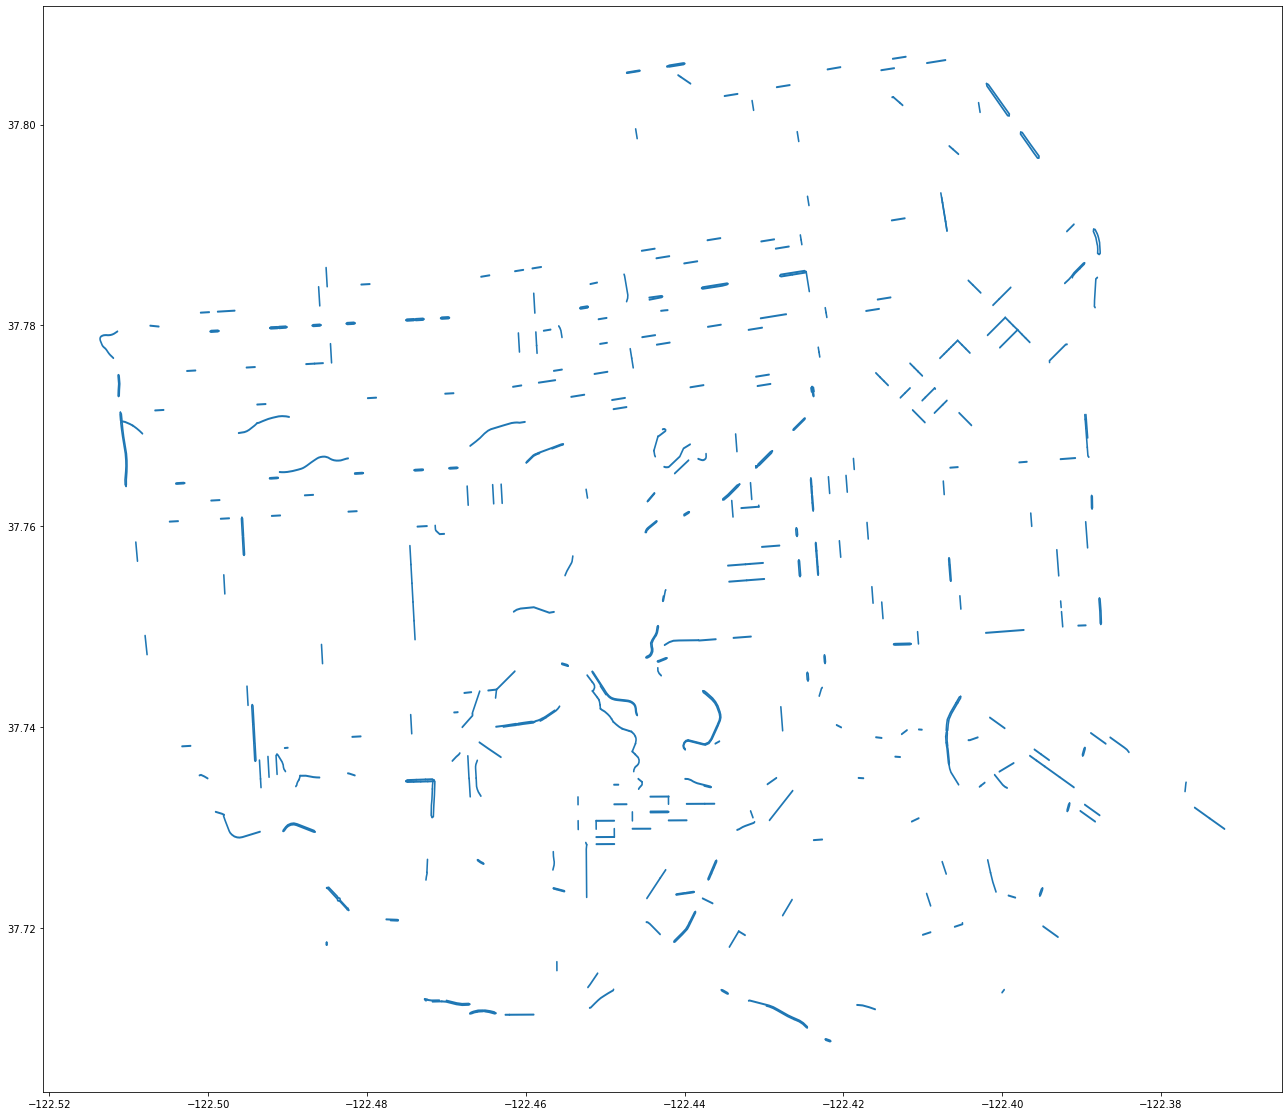

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18,20))

# Plot the footprint
merged.geometry.plot(ax=ax)
plt.tight_layout()

# 2.6 Preparing merged data for Machine Learning Model

In [42]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                555 non-null    geometry
 1   SpeedLimit              555 non-null    int64   
 2   Over_pct                555 non-null    float64 
 3   O5mph_pct               555 non-null    float64 
 4   Speed_avg               555 non-null    float64 
 5   SpeedO_avg              555 non-null    float64 
 6   Spd5O_avg               555 non-null    float64 
 7   ref                     1 non-null      object  
 8   name                    547 non-null    object  
 9   length                  555 non-null    float64 
 10  bridge                  3 non-null      object  
 11  access                  3 non-null      object  
 12  service                 1 non-null      object  
 13  junction                4 non-null      object  
 14  tunnel            

In [43]:
one_hot_cols = highway_cols + maxspeed_cols + lanes_cols
count_zeros = (merged[one_hot_cols] == 0).sum()
count_zeros

highway_busway            555
highway_living_street     555
highway_motorway          555
highway_motorway_link     555
highway_primary           465
highway_primary_link      554
highway_residential       354
highway_secondary         408
highway_secondary_link    555
highway_service           550
highway_tertiary          454
highway_tertiary_link     555
highway_trunk             554
highway_trunk_link        555
highway_unclassified      546
maxspeed_10 mph           555
maxspeed_15 mph           553
maxspeed_20 mph           550
maxspeed_25 mph           405
maxspeed_30 mph           498
maxspeed_35 mph           495
maxspeed_40 mph           551
maxspeed_45 mph           555
maxspeed_5 mph            555
maxspeed_50 mph           555
maxspeed_55 mph           555
maxspeed_65 mph           554
lanes_1                   544
lanes_2                   381
lanes_3                   478
lanes_4                   496
lanes_5                   532
lanes_6                   552
lanes_7   

In [44]:
count_zeros = count_zeros[count_zeros == 555]
count_zeros

highway_busway            555
highway_living_street     555
highway_motorway          555
highway_motorway_link     555
highway_secondary_link    555
highway_tertiary_link     555
highway_trunk_link        555
maxspeed_10 mph           555
maxspeed_45 mph           555
maxspeed_5 mph            555
maxspeed_50 mph           555
maxspeed_55 mph           555
lanes_7                   555
lanes_8                   555
dtype: int64

In [51]:
drop_cols = list(count_zeros.index)
drop_cols += ["tunnel", "width", "junction", "service","access","bridge","name", "ref","SpeedLimit"]


In [54]:
osmnx_data.drop(columns = [col for col in drop_cols if col not in ["name", "SpeedLimit"]], inplace=True)
merged.drop(columns = drop_cols, inplace=True)

In [55]:
osmnx_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   name                  32918 non-null  object  
 1   length                40567 non-null  float64 
 2   geometry              40567 non-null  geometry
 3   maxspeed_15 mph       40567 non-null  float64 
 4   maxspeed_20 mph       40567 non-null  float64 
 5   maxspeed_25 mph       40567 non-null  float64 
 6   maxspeed_30 mph       40567 non-null  float64 
 7   maxspeed_35 mph       40567 non-null  float64 
 8   maxspeed_40 mph       40567 non-null  float64 
 9   maxspeed_65 mph       40567 non-null  float64 
 10  oneway_False          40567 non-null  uint8   
 11  oneway_True           40567 non-null  uint8   
 12  lanes_1               40567 non-null  float64 
 13  lanes_2               40567 non-null  float64 
 14  lanes_3               40567 non-null  float64 

In [56]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              555 non-null    geometry
 1   Over_pct              555 non-null    float64 
 2   O5mph_pct             555 non-null    float64 
 3   Speed_avg             555 non-null    float64 
 4   SpeedO_avg            555 non-null    float64 
 5   Spd5O_avg             555 non-null    float64 
 6   length                555 non-null    float64 
 7   maxspeed_15 mph       555 non-null    float64 
 8   maxspeed_20 mph       555 non-null    float64 
 9   maxspeed_25 mph       555 non-null    float64 
 10  maxspeed_30 mph       555 non-null    float64 
 11  maxspeed_35 mph       555 non-null    float64 
 12  maxspeed_40 mph       555 non-null    float64 
 13  maxspeed_65 mph       555 non-null    float64 
 14  oneway_False          555 non-null    uint8   
 15

In [57]:
osmnx_data['centroid_X'] = osmnx_data['geometry'].centroid.x
osmnx_data['centroid_Y'] = osmnx_data['geometry'].centroid.y

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\73061768.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osmnx_data['centroid_X'] = osmnx_data['geometry'].centroid.x
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\73061768.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osmnx_data['centroid_Y'] = osmnx_data['geometry'].centroid.y


In [58]:
osmnx_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40567 entries, 0 to 40566
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   name                  32918 non-null  object  
 1   length                40567 non-null  float64 
 2   geometry              40567 non-null  geometry
 3   maxspeed_15 mph       40567 non-null  float64 
 4   maxspeed_20 mph       40567 non-null  float64 
 5   maxspeed_25 mph       40567 non-null  float64 
 6   maxspeed_30 mph       40567 non-null  float64 
 7   maxspeed_35 mph       40567 non-null  float64 
 8   maxspeed_40 mph       40567 non-null  float64 
 9   maxspeed_65 mph       40567 non-null  float64 
 10  oneway_False          40567 non-null  uint8   
 11  oneway_True           40567 non-null  uint8   
 12  lanes_1               40567 non-null  float64 
 13  lanes_2               40567 non-null  float64 
 14  lanes_3               40567 non-null  float64 

In [59]:
fileObject = open("osmnx_ml_data_set.pkl", 'wb')
pkl.dump(osmnx_data, fileObject)
fileObject.close()

In [60]:
merged['centroid_X'] = merged['geometry'].centroid.x
merged['centroid_Y'] = merged['geometry'].centroid.y
merged.drop(columns = ['geometry'], inplace=True)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\1555117437.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid_X'] = merged['geometry'].centroid.x
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23176\1555117437.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid_Y'] = merged['geometry'].centroid.y


In [61]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Over_pct              555 non-null    float64
 1   O5mph_pct             555 non-null    float64
 2   Speed_avg             555 non-null    float64
 3   SpeedO_avg            555 non-null    float64
 4   Spd5O_avg             555 non-null    float64
 5   length                555 non-null    float64
 6   maxspeed_15 mph       555 non-null    float64
 7   maxspeed_20 mph       555 non-null    float64
 8   maxspeed_25 mph       555 non-null    float64
 9   maxspeed_30 mph       555 non-null    float64
 10  maxspeed_35 mph       555 non-null    float64
 11  maxspeed_40 mph       555 non-null    float64
 12  maxspeed_65 mph       555 non-null    float64
 13  oneway_False          555 non-null    uint8  
 14  oneway_True           555 non-null    uint8  
 15  lanes_1        

In [62]:
ml_y = merged[['Over_pct','O5mph_pct','Speed_avg','SpeedO_avg','Spd5O_avg']]
ml_X = merged[[col for col in merged.columns if col not in ml_y.columns]]

In [63]:
ml_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Over_pct    555 non-null    float64
 1   O5mph_pct   555 non-null    float64
 2   Speed_avg   555 non-null    float64
 3   SpeedO_avg  555 non-null    float64
 4   Spd5O_avg   555 non-null    float64
dtypes: float64(5)
memory usage: 21.8 KB


In [64]:
ml_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                555 non-null    float64
 1   maxspeed_15 mph       555 non-null    float64
 2   maxspeed_20 mph       555 non-null    float64
 3   maxspeed_25 mph       555 non-null    float64
 4   maxspeed_30 mph       555 non-null    float64
 5   maxspeed_35 mph       555 non-null    float64
 6   maxspeed_40 mph       555 non-null    float64
 7   maxspeed_65 mph       555 non-null    float64
 8   oneway_False          555 non-null    uint8  
 9   oneway_True           555 non-null    uint8  
 10  lanes_1               555 non-null    float64
 11  lanes_2               555 non-null    float64
 12  lanes_3               555 non-null    float64
 13  lanes_4               555 non-null    float64
 14  lanes_5               555 non-null    float64
 15  lanes_6               5

In [65]:
speed_limit_data = {'data':ml_X,'target':ml_y}
fileObject = open("speed_limit_ml_data_set.pkl", 'wb')
pkl.dump(speed_limit_data, fileObject)
fileObject.close()